<a href="https://colab.research.google.com/github/ebamberg/research-projects-ml/blob/main/Document_Management/examples_build_knowledge_graph_with_instructor_framework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ollama langchain_community  --quiet

modelid="llama3.1"
emb_modelid="mxbai-embed-large"
host="localhost:11434"

get_ipython().system_raw("curl -fsSL https://ollama.com/install.sh | sh")
get_ipython().system_raw("ollama serve &")
get_ipython().system_raw(f"ollama pull {modelid}")
get_ipython().system_raw(f"ollama pull {emb_modelid}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.8/50.8 kB 2.3 MB/s eta 0:00:00


In [6]:
!pip install instructor --quiet
!apt install libgraphviz-dev
!pip install pygraphviz



Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 18 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2ubuntu2.1 [15.9 kB]
Get:4 http://archive.ubun

In [3]:

import instructor

from openai import OpenAI
from pydantic import BaseModel, Field
from typing import List

client = instructor.from_openai(
    OpenAI(
        base_url=f"http://{host}/v1",
        api_key="ollama",  # required, but unused
    ),
    mode=instructor.Mode.JSON,
)

In [10]:
from pydantic import BaseModel, Field
from typing import Optional
from graphviz import Digraph
# from IPython.display import display

class Node(BaseModel):
    id: int
    label: str
    color: str

class Edge(BaseModel):
    source: int
    target: int
    label: str
    color: str = "black"


class KnowledgeGraph(BaseModel):
    nodes: list[Node] = Field(..., default_factory=list)  # A list of nodes in the knowledge graph.
    edges: list[Edge] = Field(..., default_factory=list)  # A list of edges in the knowledge graph.


    def visualize_knowledge_graph(self):
        dot = Digraph(comment="Knowledge Graph")

        for node in self.nodes:
            dot.node(name=str(node.id), label=node.label, color=node.color)
        for edge in self.edges:
            dot.edge(str(edge.source), str(edge.target), label=edge.label, color=edge.color)
        return dot
        # return display(dot)

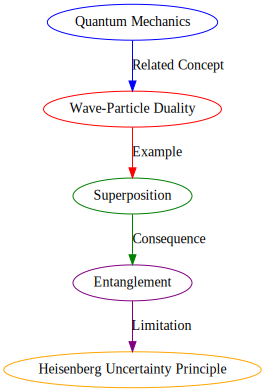

In [11]:
def generate_graph(input) -> KnowledgeGraph:
    return client.chat.completions.create(
        model=modelid,
        messages=[
            {
                "role": "user",
                "content": f"Help me understand the following by describing it as small knowledge graph: {input}",
            }
        ],
        response_model=KnowledgeGraph,
    )

graph=generate_graph("Explain quantum mechanics").visualize_knowledge_graph()
graph